<a href="https://colab.research.google.com/github/SergioCarmo-ro/monitoramento_alunos/blob/main/pythoch_aluno_tempo_real4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

PROJETO MONITORAMENTO EM TEMPO REAL_PYTHOCH


In [5]:
import os
import random
import cv2
from PIL import Image
import torch
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet18, vgg16
from torchvision.models.resnet import ResNet18_Weights
from torchvision.models.vgg import VGG16_Weights
import copy
import numpy as np
import random
import torch.optim as optim
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [6]:
def set_seed(seed=None, seed_torch=True):
  if seed is None:
    seed = np.random.choice(2 ** 32)
    random.seed(seed)
    np.random.seed(seed)
    if seed_torch:
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
    print(f'Random seed {seed} has been set.')


In [7]:
import matplotlib.pyplot as plt
import torch

def show_triplets(dataloader, n=5):
  data_iter = iter(dataloader)
  shown = 0
  plt.figure(figsize=(12, 4 * n))
  while shown < n:
        try:
            anchors, positives, negatives = next(data_iter)
        except StopIteration:
            print("End of DataLoader reached.")
            break

        for i in range(anchors.size(0)):
            if shown >= n:
                break

            for j, img in enumerate([anchors[i], positives[i], negatives[i]]):
                img = img.squeeze(0) if img.shape[0] == 1 else img  # Remove channel dim if grayscale
                plt.subplot(n, 3, shown * 3 + j + 1)
                plt.imshow(img.numpy(), cmap='gray')
                if j == 0:
                    plt.title("Anchor")
                elif j == 1:
                    plt.title("Positive")
                else:
                    plt.title("Negative")
                plt.axis('off')

            shown += 1
            plt.tight_layout()
            plt.show()

def plot_loss_curve(train_loss, val_loss):
    plt.figure(figsize=(8, 5))
    plt.plot(train_loss, label='Train Loss', marker='o')
    plt.plot(val_loss, label='Validation Loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Triplet Loss Curve')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_accuracy_curve(train_acc, val_acc):
    plt.figure(figsize=(8, 5))
    plt.plot(train_acc, label='Train Accuracy', marker='o')
    plt.plot(val_acc, label='Validation Accuracy', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Triplet Embedding Accuracy Curve')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [8]:
class TripletVGGFaceDataset(Dataset):
    def __init__(self, root_dir, transform=None, max_samples=None):

       # Argumentos:
        # root_dir (str): Caminho para o diretório 'train/' ou 'val/'.
        # transform: transformações do Torchvision a serem aplicadas.
        # max_samples (int): Comprimento do conjunto de dados (padrão: 10000).

        self.root_dir = root_dir
        self.transform = transform
        self.max_samples = max_samples or 10000

        self.class_dirs = [d for d in os.listdir(root_dir)
                           if os.path.isdir(os.path.join(root_dir, d))]

        self.image_paths = {
            cls: [os.path.join(root_dir, cls, f)
                  for f in os.listdir(os.path.join(root_dir, cls))
                  if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            for cls in self.class_dirs
        }

        # Mantenha apenas classes com >=2 imagens (necessário para trigêmeos)
        self.class_dirs = [cls for cls in self.class_dirs if len(self.image_paths[cls]) >= 2]

    def __len__(self):
        return self.max_samples

    def _load_gray_image(self, img_path):
        img = cv2.imread(img_path)
        if img is None:
            raise ValueError(f"Could not read image: {img_path}")

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        gray_pil = Image.fromarray(gray, mode='L')
        return gray_pil

    def __getitem__(self, idx):
        while True:
            try:
                anchor_cls = random.choice(self.class_dirs)
                anchor_img_path, positive_img_path = random.sample(self.image_paths[anchor_cls], 2)

                negative_cls = random.choice(self.class_dirs)
                while negative_cls == anchor_cls:
                    negative_cls = random.choice(self.class_dirs)
                negative_img_path = random.choice(self.image_paths[negative_cls])

                anchor = self._load_gray_image(anchor_img_path)
                positive = self._load_gray_image(positive_img_path)
                negative = self._load_gray_image(negative_img_path)

                if self.transform:
                    anchor = self.transform(anchor)
                    positive = self.transform(positive)
                    negative = self.transform(negative)

                return anchor, positive, negative
            except Exception as e:
                print(f"Skipping triplet: {str(e)}")

In [9]:
from torchvision import transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

train_dataset = TripletVGGFaceDataset(
    root_dir='/content/drive/MyDrive/Alunos',
    transform=transform
)

/tmp/ipython-input-3199506658.py:35: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  gray_pil = Image.fromarray(gray, mode='L')
/tmp/ipython-input-3199506658.py:35: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  gray_pil = Image.fromarray(gray, mode='L')


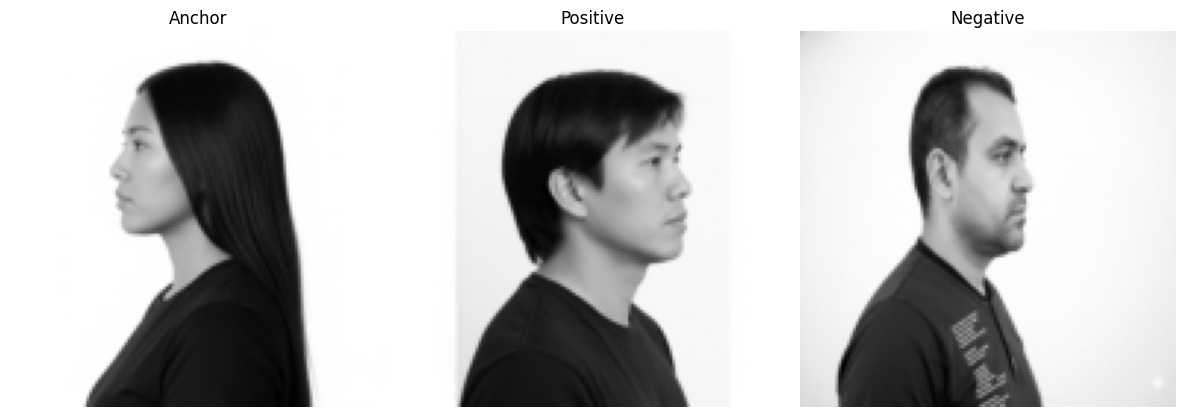

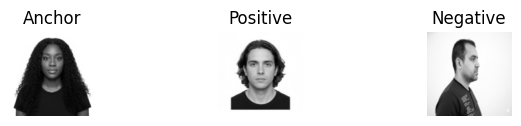

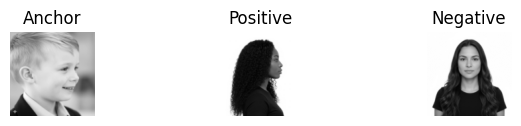

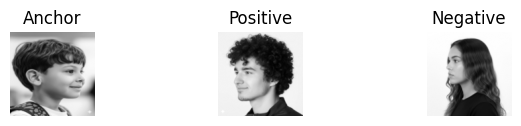

In [10]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
show_triplets(train_loader, n=4)

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.models import resnet50, ResNet50_Weights

class FeatureExtractor(nn.Module):

    # Envolva qualquer modelo de backbone e o adapte para gerar uma incorporação normalizada.

    def __init__(self, backbone, embedding_dim=128):

      # Argumentos:
      #   backbone (nn.Module): Modelo de backbone com um extrator de recursos.
      #   embedding_dim (int): Tamanho da incorporação de saída.

        super(FeatureExtractor, self).__init__()

        # Remover classificador do backbone (assume o formato padrão do torchvision)
        if hasattr(backbone, 'fc'):  # Para modelos do tipo ResNet
            self.features = nn.Sequential(*list(backbone.children())[:-1])
            in_features = backbone.fc.in_features
        elif hasattr(backbone, 'classifier'):  # Para MobileNet, etc.
            self.features = nn.Sequential(*list(backbone.children())[:-1])
            in_features = backbone.classifier[1].in_features
        else:
            raise ValueError("Arquitetura de backbone sem suporte")

        # Nova camada de incorporação

        self.embedding = nn.Linear(in_features, embedding_dim)

    def forward(self, x):

        # Passagem de encaminhamento para extrair e normalizar embeddings.

        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.embedding(x)
        return F.normalize(x, p=2, dim=1)  # L2 normalization

def load_backbone(model_name="resnet18", pretrained=True):

    # Carregar dinamicamente a arquitetura do backbone com pesos pré-treinados opcionais.

    # Argumentos:
    # model_name (str): Arquitetura do backbone (ex.: 'resnet18').
    # pretrained (bool): Se deve carregar pesos pré-treinados do ImageNet.

    # Retorna:
    # nn.Module: Modelo do backbone

    if model_name == "resnet18":
        weights = ResNet18_Weights.IMAGENET1K_V1 if pretrained else None
        model = resnet18(weights=weights)

        # Substituir a primeira camada de conversão por tons de cinza (1 canal)
        model.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=64,
            kernel_size=7,
            stride=2,
            padding=3,
            bias=False
        )
        return model
    elif model_name == "resnet50":
        weights = ResNet50_Weights.IMAGENET1K_V1 if pretrained else None
        model = resnet50(weights=weights)
        model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        return model
    else:
        raise NotImplementedError(f"Backbone '{model_name}' ainda não é suportado.")




In [12]:

class TripletNetwork(nn.Module):

    #Wrapper de rede tripleto que gera embeddings de um modelo de backbone.

    def __init__(self, model_name="resnet18", embedding_dim=128, pretrained=True):

        # Argumentos:
          # model_name (str): Nome do modelo de backbone.
          # embedding_dim (int): Tamanho da incorporação de recursos de saída.
          # pretrained (bool): Usar pesos pré-treinados ou não.

        super(TripletNetwork, self).__init__()

        # Carregue o backbone e envolva-o em um extrator de recursos
        backbone = load_backbone(model_name, pretrained)
        self.embedding_model = FeatureExtractor(backbone, embedding_dim)

    def forward(self, x):

       # Passagem direta pela rede de incorporação.

        return self.embedding_model(x)

In [13]:
def load_triplet_model(weights_path, model_name="resnet18", embedding_dim=128, pretrained=True, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = TripletNetwork(model_name=model_name, embedding_dim=embedding_dim, pretrained=pretrained)
    state_dict = torch.load(weights_path, map_location=device)
    model.load_state_dict(state_dict)
    model.to(device)
    return model

# ---- Wrapper do Classificador ----


class TripletClassifier(nn.Module):
    def __init__(self,
                 weights_path,
                 num_classes,
                 embedding_dim=128,
                 freeze_until=None,
                 model_name="resnet18",
                 pretrained=True,
                 device=None):

      # Argumentos:
        # weights_path (str): Caminho para os pesos salvos do TripletNetwork.
        # num_classes (int): Número de classes de saída.
        # embedding_dim (int): Dimensionalidade da camada de incorporação.
        # freeze_until (int ou None): Índice da camada no ResNet18 até o congelamento.
        # model_name (str): Nome da arquitetura do backbone.
        # pretrained (bool): Se o backbone deve ser inicializado com pesos do ImageNet.
        # device (str ou torch.device): Dispositivo de destino.

        super(TripletClassifier, self).__init__()

        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Carregue o TripletNetwork usando a função auxiliar
        self.backbone = load_triplet_model(
            weights_path=weights_path,
            model_name=model_name,
            embedding_dim=embedding_dim,
            pretrained=pretrained,
            device=self.device
        )

        # Congelar opcionalmente parte do backbone
        if freeze_until is not None:
            self.freeze_layers(freeze_until)

        # Adicionar uma cabeça de classificador
        self.classifier = nn.Linear(embedding_dim, num_classes)

    def freeze_layers(self, freeze_until):
        modules = list(self.backbone.embedding_model.features.children())
        for i, layer in enumerate(modules):
            if i < freeze_until:
                for param in layer.parameters():
                    param.requires_grad = False

    def forward(self, x):
        embedding = self.backbone(x)
        logits = self.classifier(embedding)
        return logits

In [14]:
from sklearn.metrics import f1_score

def compute_accuracy(anchor, positive, negative):
    pos_dist = F.pairwise_distance(anchor, positive, p=2)
    neg_dist = F.pairwise_distance(anchor, negative, p=2)
    correct = (pos_dist < neg_dist).sum().item()
    total = anchor.size(0)
    return correct, total

In [15]:
def train_triplet_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    num_epochs,
    device,
    save_path='best_model.pth',
    use_tqdm=True,
    scheduler=None
):
    model = model.to(device)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_loss = float('inf')

    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': [],
        'train_f1': [],
        'val_f1': []
    }

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}\n' + '-'*30)

        # -------- Train --------
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        train_preds = []
        train_labels = []

        if use_tqdm:
            train_iter = tqdm(train_loader, desc='training')
        else:
            train_iter = train_loader

        for anchor, positive, negative in train_iter:
            anchor = anchor.to(device)
            positive = positive.to(device)
            negative = negative.to(device)

            optimizer.zero_grad()

            anchor_out = model(anchor)
            positive_out = model(positive)
            negative_out = model(negative)

            loss = criterion(anchor_out, positive_out, negative_out)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            # Accuracy and F1
            with torch.no_grad():
                correct, total = compute_accuracy(anchor_out, positive_out, negative_out)
                train_correct += correct
                train_total += total
                preds = (F.pairwise_distance(anchor_out, positive_out) < F.pairwise_distance(anchor_out, negative_out)).long().cpu().numpy()
                labels = np.ones_like(preds)
                train_preds.extend(preds)
                train_labels.extend(labels)

        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = train_correct / train_total if train_total > 0 else 0
        train_f1 = f1_score(train_labels, train_preds)

        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(train_accuracy)
        history['train_f1'].append(train_f1)

        print(f'Train Loss: {avg_train_loss:.4f} | Accuracy: {train_accuracy:.4f} | F1: {train_f1:.4f}')

        # -------- Validate --------
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        val_preds = []
        val_labels = []

        with torch.no_grad():
            if use_tqdm:
                val_iter = tqdm(val_loader, desc='validating')
            else:
                val_iter = val_loader

            for anchor, positive, negative in val_iter:
                anchor = anchor.to(device)
                positive = positive.to(device)
                negative = negative.to(device)

                anchor_out = model(anchor)
                positive_out = model(positive)
                negative_out = model(negative)

                loss = criterion(anchor_out, positive_out, negative_out)
                val_loss += loss.item()

                correct, total = compute_accuracy(anchor_out, positive_out, negative_out)
                val_correct += correct
                val_total += total
                preds = (F.pairwise_distance(anchor_out, positive_out) < F.pairwise_distance(anchor_out, negative_out)).long().cpu().numpy()
                labels = np.ones_like(preds)
                val_preds.extend(preds)
                val_labels.extend(labels)

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = val_correct / val_total if val_total > 0 else 0
        val_f1 = f1_score(val_labels, val_preds)
        if scheduler is not None:
            scheduler.step(avg_val_loss)

        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(val_accuracy)
        history['val_f1'].append(val_f1)

        print(f'Val Loss: {avg_val_loss:.4f} | Accuracy: {val_accuracy:.4f} | F1: {val_f1:.4f}')

        # -------- Save Best Model --------
        if avg_val_loss < best_val_loss:
            print(f'Saving best model (Val Loss improved from {best_val_loss:.4f} → {avg_val_loss:.4f})')
            best_val_loss = avg_val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(best_model_wts, save_path)

    print(f'\nTraining complete. Best Val Loss: {best_val_loss:.4f}')

    # Carregar e retornar o melhor modelo + histórico de treinamento
    model.load_state_dict(best_model_wts)
    return model, history

*  Main

In [ ]:
import matplotlib.pyplot as plt

# 1. Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 2. Instanciar o modelo
model = TripletNetwork(model_name='resnet50', embedding_dim=512)

# 3. Definir a função de perda (triplet loss)
criterion = nn.TripletMarginLoss(margin=1.0, p=2)

# 4. Definir o otimizador e scheduler
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=4)

# 5. Data augmentations
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(128, scale=(0.6, 1.0), ratio=(0.75, 1.33)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=20),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.25, scale=(0.02, 0.1), ratio=(0.3, 3.3)),
])
val_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

train_dataset = TripletVGGFaceDataset(
    root_dir='/content/drive/MyDrive/Alunos',
    transform=train_transform
)
val_dataset = TripletVGGFaceDataset(
    root_dir='/content/drive/MyDrive/Alunos',
    transform=val_transform
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

# 6. Função de treino (aquela corrigida anteriormente)
# def train_triplet_model...

# 7. Treine e salve o melhor modelo
best_model, history = train_triplet_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=4,
    device=device,
    save_path='melhor_modelo_triplet.pth',
    use_tqdm=True,
    scheduler=scheduler
)

# 8. Visualize as curvas de loss e accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Perda de Treinamento')
plt.plot(history['val_loss'], label='Perda de Validação')
plt.title('Curva de Perda (Loss)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Acurácia Treinamento')
plt.plot(history['val_acc'], label='Acurácia Validação')
plt.title('Curva de Acurácia')
plt.legend()
plt.tight_layout()
plt.show()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 161MB/s]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 1/4
------------------------------


training:   0%|          | 0/313 [00:00<?, ?it/s]/tmp/ipython-input-3199506658.py:35: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  gray_pil = Image.fromarray(gray, mode='L')
/tmp/ipython-input-3199506658.py:35: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  gray_pil = Image.fromarray(gray, mode='L')
/tmp/ipython-input-3199506658.py:35: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  gray_pil = Image.fromarray(gray, mode='L')
/tmp/ipython-input-3199506658.py:35: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  gray_pil = Image.fromarray(gray, mode='L')
training:  42%|████▏     | 130/313 [54:27<1:14:34, 24.45s/it]

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Subplot para a Perda (Loss)
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Perda de Treinamento')
plt.plot(history['val_loss'], label='Perda de Validação')
plt.title('Curva de Perda (Loss)')
plt.ylabel('Perda')
plt.xlabel('Época')
plt.legend()

# Subplot para a Acurácia (Accuracy)
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Acurácia de Treinamento')
plt.plot(history['val_acc'], label='Acurácia de Validação')
plt.title('Curva de Acurácia')
plt.ylabel('Acurácia')
plt.xlabel('Época')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# --- Variáveis que você precisa definir ou já tem ---
# Para que este código funcione para classificação, você precisaria de:
# 1. Um conjunto de dados de teste (imagens) e seus rótulos verdadeiros.
#    Exemplo: X_test (imagens tensorizadas), y_test (rótulos de classe)
# 2. Um modelo de classificação (como TripletClassifier, treinado ou com pesos carregados).
#    Atualmente, 'model' é um TripletNetwork que produz embeddings, não classificações diretas.

# Exemplo de como você definiria X_test e y_test (SUBSTITUA POR SEUS DADOS REAIS)
# Se você não tem um conjunto de teste de classificação, pode usar alguns exemplos do val_loader
# ou de um novo DataLoader específico para teste.
# Para este exemplo, X_test e y_test são placeholders e precisarão ser definidos de verdade.
# X_test = torch.randn(10, 1, 128, 128) # Exemplo: 10 imagens monocromáticas de 128x128
# y_test = torch.randint(0, 3, (10,)) # Exemplo: 10 rótulos para 3 classes

# Lista com os nomes das classes (substitua pelos nomes reais do seu conjunto de dados de classificação)
class_names = ['Nome_Classe_0', 'Nome_Classe_1', 'Nome_Classe_2'] # <--- SUBSTITUA AQUI

# --- Demonstração de como fazer inferência com um modelo de CLASSIFICAÇÃO ---
# O 'model' atual (TripletNetwork) produz embeddings. Para classificação,
# você precisaria instanciar e, opcionalmente, treinar/carregar um TripletClassifier.

# Exemplo conceitual para um TripletClassifier (você precisaria carregá-lo/treiná-lo):
# num_classes = len(class_names)
# classification_model = TripletClassifier(
#     weights_path='melhor_modelo_triplet.pth', # Caminho para os pesos do embedding
#     num_classes=num_classes,
#     embedding_dim=512, # Mesma dimensão do embedding que você treinou
#     model_name='resnet50',
#     device=device # 'device' precisa estar definido
# ).to(device)
# classification_model.eval()

# --- Para este exemplo, vamos simular previsões, pois X_test e y_test não estão definidos ---
# Se você tivesse um 'classification_model' e 'X_test' e 'y_test' reais:
# with torch.no_grad():
#     logits = classification_model(X_test.to(device))
#     probabilities = torch.softmax(logits, dim=1)
#     predictions = probabilities.cpu().numpy() # Mova para CPU e converta para NumPy
#     # y_test (rótulos verdadeiros) também precisariam ser convertidos para NumPy se forem tensor

# placeholder for demonstration - in a real scenario, 'predictions' would come from your model
# Make sure X_test and y_test are actually defined and populated with real data.
# For now, let's create dummy data for X_test and predictions for the plot to run without error
# You MUST replace this with your actual test data and model predictions.

# Dummy data for demonstration purposes (REMOVE IN REAL USAGE)
if 'X_test' not in locals():
    X_test = np.random.rand(5, 128, 128) * 255 # 5 grayscale images
    y_test = np.random.randint(0, len(class_names), 5) # 5 random labels
    # Dummy predictions (replace with actual model output)
    dummy_probs = np.random.rand(5, len(class_names))
    predictions = dummy_probs / dummy_probs.sum(axis=1, keepdims=True)


# 2. Plotar as N primeiras imagens e suas classificações
num_images_to_show = min(len(X_test), 5) # <--- Defina quantas imagens quer mostrar

for i in range(num_images_to_show):
    plt.figure(figsize=(6, 6))

    # Exibir a imagem
    # Certifique-se de que a imagem está no formato correto para plt.imshow (H, W) ou (H, W, C)
    # E no tipo de dados correto (geralmente uint8 ou float entre 0 e 1)
    plt.imshow(X_test[i].astype('uint8') if X_test[i].ndim == 2 else X_test[i].transpose(1, 2, 0).astype('uint8'), cmap='gray')

    # Rótulo Verdadeiro
    # y_test deve conter os índices das classes (não one-hot encoded para este formato)
    true_label_index = y_test[i]
    true_class_name = class_names[true_label_index]

    # Previsão do Modelo
    predicted_label_index = np.argmax(predictions[i])
    confidence = predictions[i][predicted_label_index] * 100
    predicted_class_name = class_names[predicted_label_index]

    # Determinar a cor do rótulo (verde para acerto, vermelho para erro)
    color = 'green' if predicted_label_index == true_label_index else 'red'

    title_text = f"Verdadeiro: {true_class_name}"
    xlabel_text = f"Predito: {predicted_class_name} ({confidence:.2f}%)"

    plt.title(title_text)
    plt.xlabel(xlabel_text, color=color, fontsize=12)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [ ]:
# 1. Get class names and mapping from the existing dataset
# Assuming train_dataset has been initialized and contains class_dirs
class_names = sorted(train_dataset.class_dirs) # Sort for consistent mapping
num_classes = len(class_names)
class_to_idx = {name: i for i, name in enumerate(class_names)}
idx_to_class = {i: name for i, name in enumerate(class_names)}

print(f"Found {num_classes} classes: {class_names}")

# 2. Instantiate and load TripletClassifier
# Ensure 'device' is defined (it should be from previous cells)
classification_model = TripletClassifier(
    weights_path='melhor_modelo_triplet.pth', # Path to the embedding weights
    num_classes=num_classes,
    embedding_dim=512, # Same embedding dimension as trained (resnet50 default)
    model_name='resnet50',
    pretrained=False, # Weights are loaded from weights_path, so don't re-initialize with ImageNet
    device=device
).to(device)
classification_model.eval() # Set the model to evaluation mode

# 3. Create a test dataset for classification
class ClassificationTestDataset(Dataset):
    def __init__(self, root_dir, class_to_idx, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.class_to_idx = class_to_idx
        self.samples = [] # List of (image_path, class_idx)

        for class_name in sorted(os.listdir(root_dir)): # Iterate through sorted class directories
            class_path = os.path.join(root_dir, class_name)
            if not os.path.isdir(class_path) or class_name not in class_to_idx:
                continue

            class_idx = class_to_idx[class_name]
            for img_name in os.listdir(class_path):
                if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                    self.samples.append((os.path.join(class_path, img_name), class_idx))

    def _load_gray_image(self, img_path):
        img = cv2.imread(img_path)
        if img is None:
            raise ValueError(f"Could not read image: {img_path}")
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        gray_pil = Image.fromarray(gray, mode='L')
        return gray_pil

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = self._load_gray_image(img_path)

        if self.transform:
            image = self.transform(image)
        return image, label

# Use the same validation transform for consistency in testing
test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# Create the test dataset and loader
test_dataset = ClassificationTestDataset(
    root_dir='/content/drive/MyDrive/Alunos', # Use the same root as your other datasets
    class_to_idx=class_to_idx,
    transform=test_transform
)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2) # num_workers adjusted to 2

print(f"Number of test samples: {len(test_dataset)}")

# 4. Perform inference and collect results
all_preds = []
all_labels = []
all_images = []
all_probabilities = [] # To store probabilities for confidence scores

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        logits = classification_model(images)
        probabilities = torch.softmax(logits, dim=1)
        _, predicted = torch.max(probabilities, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_images.extend(images.cpu().numpy())
        all_probabilities.extend(probabilities.cpu().numpy())

# Convert lists to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_images = np.array(all_images)
all_probabilities = np.array(all_probabilities)

# 5. Display some example classifications
num_images_to_show = min(len(all_images), 10) # Show up to 10 images

plt.figure(figsize=(15, num_images_to_show * 3))
for i in range(num_images_to_show):
    plt.subplot(num_images_to_show // 5 + 1, 5, i + 1) # Adjust subplot grid as needed

    img = all_images[i].squeeze(0) # Remove channel dimension for grayscale
    plt.imshow(img, cmap='gray')

    true_label_index = all_labels[i]
    true_class_name = idx_to_class[true_label_index]

    predicted_label_index = all_preds[i]
    predicted_class_name = idx_to_class[predicted_label_index]

    confidence = all_probabilities[i, predicted_label_index] * 100

    color = 'green' if predicted_label_index == true_label_index else 'red'

    title_text = f"True: {true_class_name}"
    xlabel_text = f"Pred: {predicted_class_name} ({confidence:.2f}%)"

    plt.title(title_text, fontsize=8)
    plt.xlabel(xlabel_text, color=color, fontsize=8)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

# 6. Calculate overall accuracy
accuracy = (all_preds == all_labels).sum() / len(all_labels)
print(f"\nOverall Classification Accuracy: {accuracy*100:.2f}%")